In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [65]:
import os
print(os.listdir("/data2/kaylee/kaylee/music-score-gen/data/emotifymusic/joyful_activation"))

['287.mp3', '95.mp3', '375.mp3', '197.mp3', '43.mp3', '223.mp3', '335.mp3', '398.mp3', '216.mp3', '78.mp3', '391.mp3', '264.mp3', '173.mp3', '71.mp3', '272.mp3', '119.mp3', '380.mp3', '209.mp3', '358.mp3', '12.mp3', '298.mp3', '125.mp3', '52.mp3', '3.mp3', '181.mp3', '296.mp3', '79.mp3', '132.mp3', '30.mp3', '198.mp3', '281.mp3', '250.mp3', '140.mp3', '257.mp3', '39.mp3', '54.mp3', '85.mp3', '28.mp3', '362.mp3', '156.mp3', '26.mp3', '123.mp3', '388.mp3', '111.mp3', '206.mp3', '61.mp3', '129.mp3', '50.mp3', '81.mp3', '59.mp3', '88.mp3', '313.mp3', '368.mp3', '230.mp3', '169.mp3', '10.mp3', '328.mp3', '62.mp3', '167.mp3', '385.mp3', '65.mp3', '213.mp3', '214.mp3', '103.mp3', '379.mp3', '34.mp3', '138.mp3', '282.mp3', '144.mp3', '90.mp3', '18.mp3', '383.mp3', '64.mp3', '276.mp3', '278.mp3', '23.mp3', '126.mp3', '24.mp3', '236.mp3', '7.mp3', '128.mp3', '80.mp3', '292.mp3', '194.mp3', '40.mp3', '255.mp3', '378.mp3', '215.mp3', '269.mp3', '179.mp3', '336.mp3', '212.mp3', '395.mp3']


In [84]:
music_dir = "/data2/kaylee/kaylee/music-score-gen/data/emotifymusic"

# try classical melody in electronic tone
# emotion = 'joyful_activation'
# content = '88'
# style = '296'

# try lyrics
emotion = 'joyful_activation'
content = '173'
style = '212'

# percussive beat: tension 211
CONTENT_FILENAME = "%s/%s/%s.mp3" %(music_dir, emotion, content)
STYLE_FILENAME = "%s/%s/%s.mp3" %(music_dir, emotion, style)

In [85]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [86]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [87]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

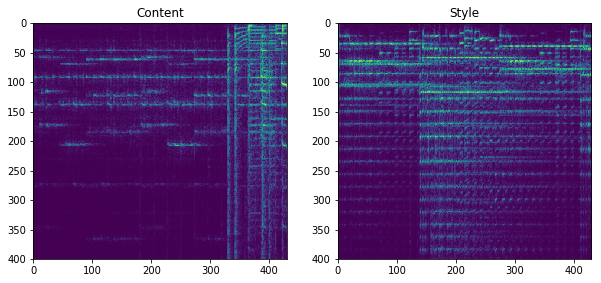

In [88]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [89]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [104]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    #content_loss = ALPHA * 2 * tf.nn.l2_loss(
    #        net - content_features)
    content_loss = ALPHA * 2 * tf.nn.l2_loss(net, content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    # style_loss = 2 * tf.nn.l2_loss(gram - style_gram)
    style_loss = tf.reduce_mean(tf.nn.log_poisson_loss(gram, style_gram)) # log pois loss

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Invert spectrogram and save the result

In [ ]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/%s_%s_%s_%s.wav' %(emotion, content, style , 'log_pois_loss')
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [102]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [103]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/joyful_activation_173_212_baseline.wav


### Visualize spectrograms

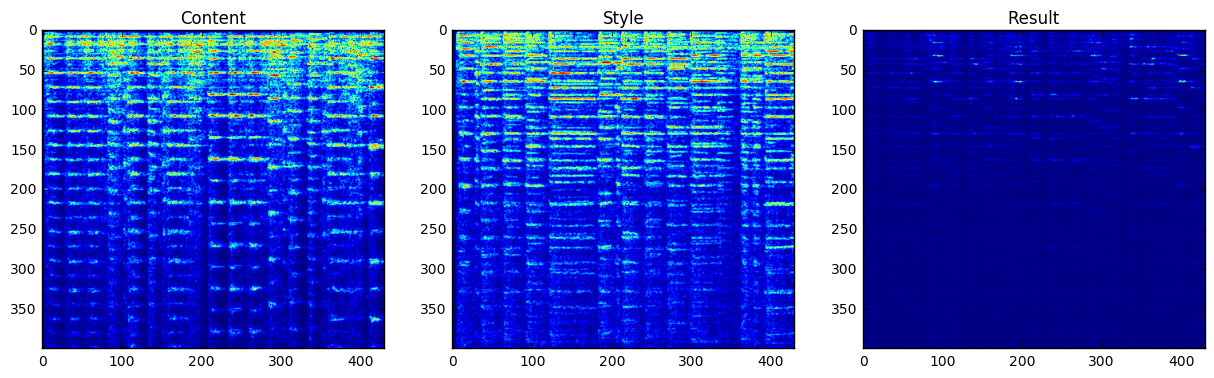

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()